In [1]:
# Import libraries
import keras
from keras import backend as k
import keras_tuner
import xarray as xr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

2024-02-22 10:12:01.267454: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 10:12:01.645526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# XAI Workflow:
### Concept: 
Based on Ishikawa et al. 2023. The test sample feature vector from the classification/siamese model will be compared with all samples from the training data to identify the most similar samples. These samples will be shown to the User to help build confidence in the classification provided by the model. 

### Steps:
1) Load the training data
2) Load the model
3) Obtain feature vectors for training data
4) Load test sample
5) Classify test sample
6) Obtain test feature vector
7) Compare test feature vector with all training samples to identify best match for (analyse best norm option):
   1) same class
   2) other classes
8) Plot similar images with lowest feature vector distance scores 

# Load the training data
This is the data that was used to train the classification/siamese model. This data forms the base for the XAI workflow. 

Note: For the siamese network, it is important to identify the tree images used to form the pairs for the model. This is done here using the following datasets: training_data.zarr which contains the siamese pairs and foresttree.zarr which contains individual images obtained using the geocoded_object_extractor.

In [2]:
# Data used for training the siamese network in image pairs
data = xr.open_zarr('../../data/reforestree/processed/training_data.zarr')
data

<xarray.Dataset>
Dimensions:     (sample: 2592, pair: 2, x: 400, y: 400, channel: 3)
Dimensions without coordinates: sample, pair, x, y, channel
Data variables:
    X           (sample, pair, x, y, channel) float32 dask.array<chunksize=(10, 2, 400, 400, 3), meta=np.ndarray>
    Y           (sample) int64 dask.array<chunksize=(10,), meta=np.ndarray>
    index_pair  (sample, pair) int64 dask.array<chunksize=(10, 2), meta=np.ndarray>

In [3]:
# Individual cut-out of trees extracted from reforestree dataset
imdata = xr.open_zarr('../../data/reforestree/processed/foresttree.zarr/')
imdata

<xarray.Dataset>
Dimensions:  (sample: 3178, x: 400, y: 400, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
    Y        (sample) int64 dask.array<chunksize=(1,), meta=np.ndarray>

In [4]:
# Subsample imdata to obtain only data that was used to train the siamese model
siamese_data = imdata.isel(sample=np.unique(data.index_pair[:,:]))

In [5]:
# The training data is split into a dictionary of samples per class to facilitate ease of comparison 
# Due to memory limitation, currently restricting the samples to 100 for each class in the training data
# NOTE: All the training data needs to be used in an actual run - to do so, please remove the last isel in line 6: .isel(sample=range(100))
classes =  np.unique(siamese_data.Y.values)
class_data = {}
for class_i in classes:
    class_data[class_i] = siamese_data.where(siamese_data.Y.compute()==class_i, drop=True).isel(sample=range(100))

# Load the Model

In [6]:
# Model creation
def _create_model(nneurons, nfilters, ndropout, npool):
    # 4 layers
    inputs = keras.Input((400, 400, 3))
    
    x = keras.layers.Conv2D(nneurons[0], (nfilters[0], nfilters[0]), padding="same", activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[0], npool[0]), data_format='channels_last')(x)

    x = keras.layers.Conv2D(nneurons[1], (nfilters[1], nfilters[1]), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[1], npool[1]), data_format='channels_last')(x)

    x = keras.layers.Conv2D(nneurons[2], (nfilters[2], nfilters[2]), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[2], npool[2]), data_format='channels_last')(x)

    x = keras.layers.Conv2D(nneurons[3], (nfilters[3], nfilters[3]), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(npool[3], npool[3]), data_format='channels_last')(x)
    x = keras.layers.Dropout(ndropout[0])(x)

    pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = keras.layers.Dense(nneurons[4])(pooledOutput)
    outputs = keras.layers.Dense(nneurons[5])(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model

def _euclidean_distance(vectors):
    (featA, featB) = vectors
    squared = k.square(featA-featB)
    return squared

def siamese_model(nneurons, nfilters, ndropout, npool):
    feature_extractor_model = _create_model(nneurons, nfilters, ndropout, npool)
    imgA = keras.Input(shape=(400, 400, 3))
    imgB = keras.Input(shape=(400, 400, 3))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(_euclidean_distance)([featA, featB])
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    return model

In [7]:
# Create siamese model
nneurons = [32, 64, 64, 128, 256, 128]
nfilters = [3, 3, 5, 5]
ndropout = [0.4]
npool = [4, 4, 4, 4]
siamesemodel = siamese_model(nneurons, nfilters, ndropout, npool)

In [8]:
# load weights - note that this includes 2 additional weights for the output layer 
siamesemodel.load_weights('./optimized_models/optimized_weights.h5')

In [9]:
# Create a model to extract feature vectors from weights of the trained model
feature_extractor_model = _create_model(nneurons, nfilters, ndropout, npool)
feature_extractor_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 400, 400, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 400, 400, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 100, 100, 64)      256 

In [12]:
# Set the weights of the extractor model to the weights trained in the siamese model.  
feature_extractor_model.set_weights(siamesemodel.weights[:28])

In [13]:
for i in range (len(feature_extractor_model.weights)):
    print (i, np.max(np.array(feature_extractor_model.weights[i])))

0 0.14714114
1 0.008765133
2 1.0170373
3 0.014830711
4 0.2857605
5 0.124825455
6 0.10410021
7 0.01647783
8 1.0276204
9 0.014903684
10 1.5238405
11 3.4748318
12 0.06815867
13 0.013237686
14 1.0293243
15 0.019975992
16 5.395604
17 32.798866
18 0.062769346
19 0.030249763
20 1.0050695
21 0.022806963
22 4.9894876
23 13.2572365
24 0.14908087
25 0.0
26 0.14927463
27 0.0


# Obtain feature vectors for training data

In [14]:
# Obtain features of the training data for each class
class_features = {}
for class_i in classes:
    class_features[class_i] = feature_extractor_model.predict(class_data[class_i].X[0:32].to_numpy(), batch_size=32)
    for i in range(int(class_data[class_i].X.shape[0]/32)):
        vecs = feature_extractor_model.predict(class_data[class_i].X[(i+1)*32:(i+2)*32].to_numpy(), batch_size=32)
        class_features[class_i] = np.append(class_features[class_i], vecs, axis=0) 

1/1 [==============================] - 0s 49ms/step


# Load Test Sample

In this case, we will load a sample from the original data-set that was not used for training (sample: 3005).

In [15]:
test_sample = imdata.isel(sample=3005)

# Classify test sample

#### TO DO: Create pairs with test sample for each individual class and test using siamese network for classification.

For now, we assume that the class is the same as the image label from the data-set which is available in test_sample.Y

In [16]:
test_sample.Y.values

array(2)

# Obtain test feature vector

In [17]:
test_feature_vector = feature_extractor_model.predict(np.array([test_sample.X.to_numpy()]))

1/1 [==============================] - 0s 41ms/step


# Compare test feature vector 
Test feature vector is to be compared with all training samples to identify best match for (analyse best norm option):
   1) same class
   2) other classes

In [19]:
# TO BE REMOVED ONCE A GOOD FEATURE EXTRACTOR MODEL IS TRAINED
for class_i in classes:
    class_features[class_i] = np.random.rand(class_features[class_i].shape[0], class_features[class_i].shape[1])
test_feature_vector = np.random.rand(test_feature_vector.shape[0], test_feature_vector.shape[1])

In [20]:
# Calculate cosine, l1, and l2 distances for test sample for every sample in each class of the training data 
cosine_dist = {}
l1_dist = {}
l2_dist = {}
for class_i in classes:
    cosine_dist[class_i] = cosine_distances(class_features[class_i], test_feature_vector)
    l2_dist[class_i] = euclidean_distances(class_features[class_i], test_feature_vector)
    l1_dist[class_i] = manhattan_distances(class_features[class_i], test_feature_vector)

### Obtain best match for each class for each distance metric

In [21]:
best_cosine_match = {}
best_l1_match = {}
best_l2_match = {}
for class_i in classes:
    best_cosine_match[class_i] = np.argmin(cosine_dist[class_i])
    best_l2_match[class_i] = np.argmin(l2_dist[class_i])
    best_l1_match[class_i] = np.argmin(l1_dist[class_i])

# Plot similar images with lowest feature vector distance scores 

#### Cosine plot

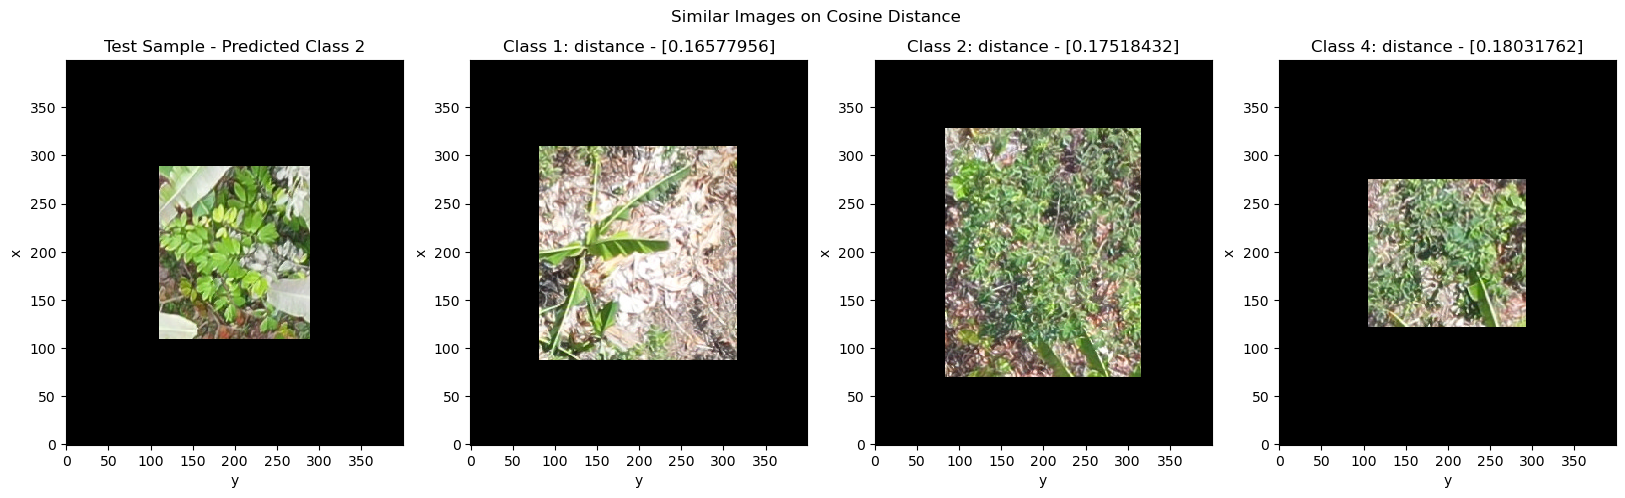

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on Cosine Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {test_sample.Y.values}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_cosine_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {cosine_dist[class_i][best_cosine_match[class_i]]}')

#### L1 Plot

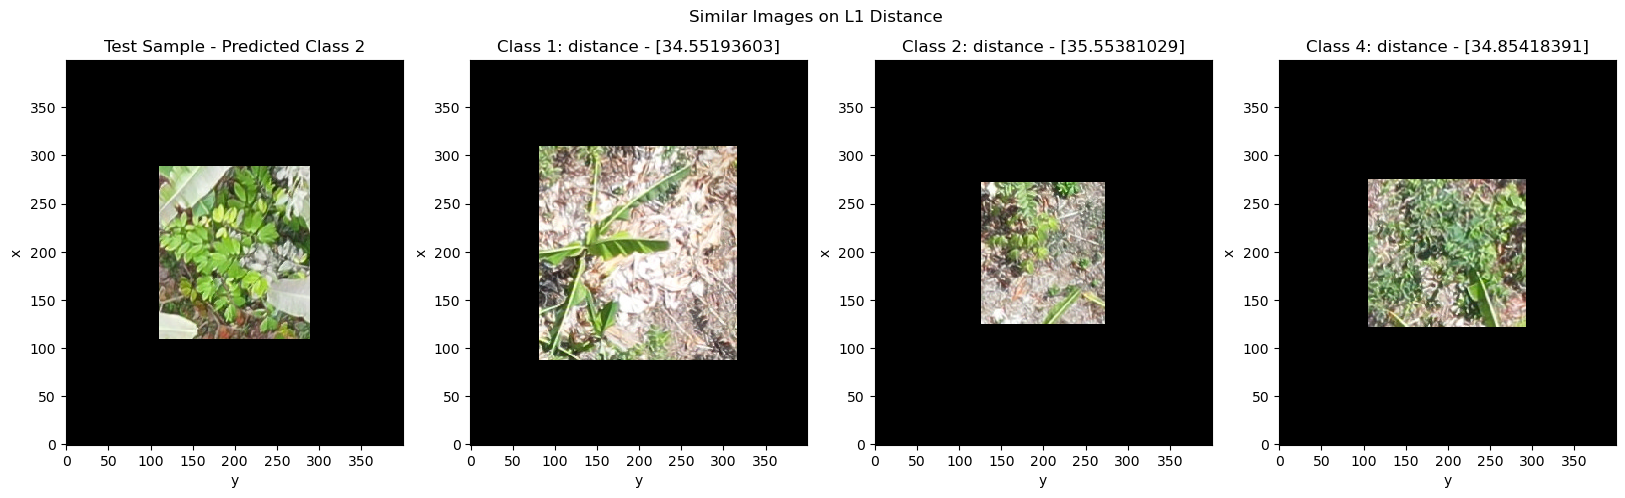

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on L1 Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {test_sample.Y.values}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_l1_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {l1_dist[class_i][best_l1_match[class_i]]}')

#### L2 Plot

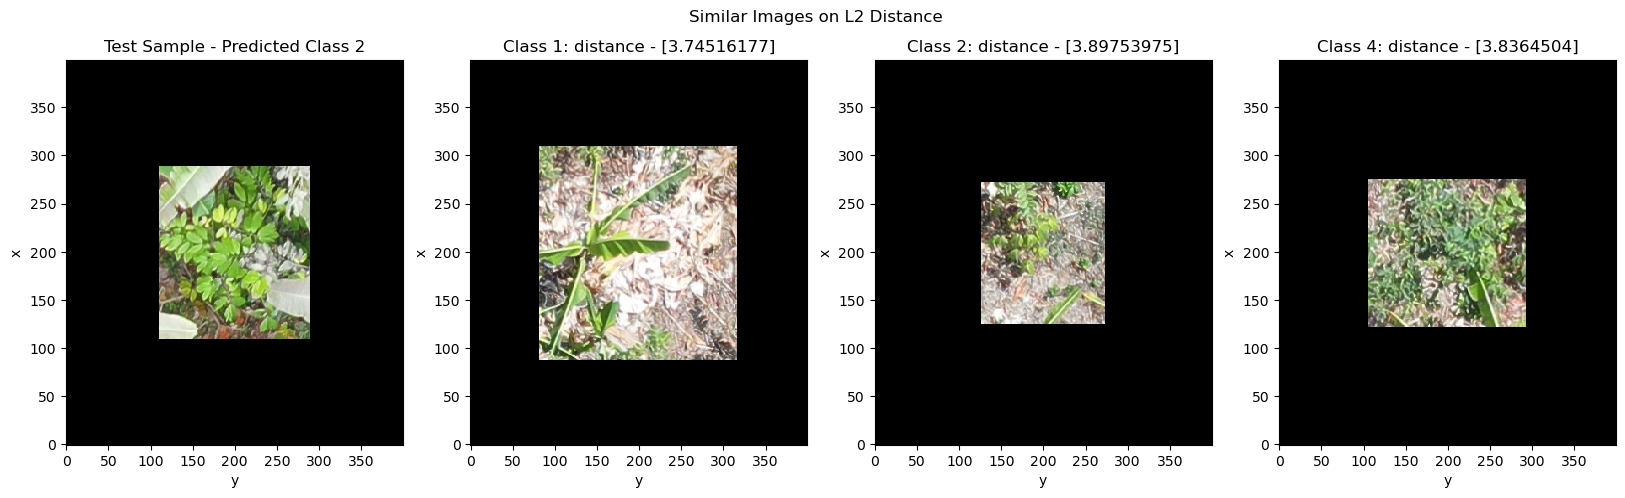

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on L2 Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {test_sample.Y.values}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_l2_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {l2_dist[class_i][best_l2_match[class_i]]}')